## S-Mobile: Predicting Customer Churn
* Team-lead GitLab id: sguniset
* Group name: Avengers
* Team member names: Ines - Mouli - Srikar - Xuefei

## Setup

Please complete this Jupyter notebook by answering the questions in `s-mobile.pdf` on Canvas (week9/). Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML from the Jupyter Notebook file without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the fourth group assignment for MGTA 455 and you will be using git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". git will not decide for you who's change to accept so the team-lead will have to determine which edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import os
import urllib.request
import zipfile

import numpy as np
import pandas as pd
import pyrsm as rsm

from math import sqrt
from tempfile import NamedTemporaryFile as tmpfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance, plot_partial_dependence

import xgboost as xgb

sns.set_theme(style="darkgrid", palette="muted")

# increase plot resolution
mpl.rcParams["figure.dpi"] = 100

In [3]:
## load the data - this dataset must NOT be changed
s_mobile = pd.read_pickle("data/s_mobile.pkl")
s_mobile["churn_yes"] = rsm.ifelse(s_mobile["churn"] == "yes", 1, 0)
s_mobile.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,smartphone,highcreditr,mcycle,car,travel,region,occupation,training,representative,churn_yes
0,U86940794,yes,109,81,62,600,141,0,0,8,...,yes,no,no,no,no,CS,other,0.0,0,1
1,U56788559,no,0,3,54,146,0,0,0,8,...,yes,yes,no,no,no,SE,other,0.0,0,0
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,yes,no,yes,no,yes,NW,professional,NaN,1,0
3,U75794640,no,0,-8,35,560,0,0,0,37,...,yes,yes,yes,no,no,NW,retired,1.0,0,0
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,yes,no,yes,yes,no,SW,other,NaN,1,0


If you want access to the full 1M row dataset, use the code below to download and use the data. Please do **not** include the 1M row dataset in your repo!

The downside to using the dataset with 1M rows is, of course, that estimation time will increase substantially. I do NOT recommend you use this dataset to select your final model or for tuning hyper parameters. You can, however, use this larger dataset to re-estimate your chosen model and generate profit estimates for the representative sample.

In [3]:
## uncomment to run
# url = "https://www.dropbox.com/s/xhiexneeok9gyhs/s_mobile_1M.pkl.zip?dl=1"
# file_path, _ = urllib.request.urlretrieve(url)
# zip_file = zipfile.ZipFile(file_path, "r")
# s_mobile_tmp = zip_file.open(zip_file.namelist()[0])
# os.remove(file_path)
# s_mobile = pd.read_pickle(s_mobile_tmp)

In [4]:
# show dataset description
rsm.describe(s_mobile)

## S-mobile

Dataset used to investigate opportunities to decrease customer churn at S-mobile. The sample consists of three parts:

1. A training sample with 27,300 observations and a 50% churn rate ("training == 1")
2. A test sample with 11,700 observations and a 50% churn rate ("training == 0")
3. A representative sample with 30,000 observations and a churn rate of 2%, i.e., the actual monthly churn rate for S-mobile ("is.na(training)" or "representative == 1")

## Variables

* customer: Customer ID
* churn: Did consumer churn in the last 30 days? (yes or no)
* changer: % change in revenue over the most recent 4 month period
* changem: % change in minutes of use over the most recent 4 month period
* revenue: Mean monthly revenue in SGD
* mou: Mean monthly minutes of use
* overage: Mean monthly overage minutes
* roam: Mean number of roaming calls
* conference: Mean number of conference calls
* months: # of months the customer has had service with S-Mobile
* uniqsubs: Number of individuals listed on the customer account
* custcare: Mean number of calls to customer care 
* retcalls: Number of calls by the customer to the retention team
* dropvce: Mean number of dropped voice calls 
* eqpdays: Number of days customer has owned current handset
* refurb: Handset is refurbished (no or yes)
* smartphone: Handset is a smartphone (no or yes)
* creditr: High credit rating as opposed to medium or low (no or yes)
* mcycle: Subscriber owns a motorcycle (no or yes)
* car: Subscriber owns a car (no or yes)
* travel: Subscriber has traveled internationally (no or yes)
* region: Regions delineated by the 5 Community Development Council Districts (e.g., CS is Central Singapore)
* occupation: Categorical variable with 4 occupation levels (professional, student, retired, or other)
* training: 1 for training sample, 0 for test sample, NA for representative sample
* representative: 1 for representative sample, 0 for training and test sample


### <u> EXPLORE THE DATA </u>

In [5]:
# Descriptive statistics for training data
pd.get_dummies(
    s_mobile.loc[s_mobile.training == 1, "churn":],
).agg(["mean", "std", "min", "max"]).T

,mean,std,min,max
changer,8.661245,28.956823,-62.0,305.0
changem,15.211392,51.885577,-78.0,521.0
revenue,57.211136,43.258950,0.0,856.0
mou,515.322308,525.458925,0.0,7668.0
overage,66.274286,69.258068,0.0,283.0
roam,1.197253,7.254327,0.0,692.0
conference,0.263480,1.083898,0.0,56.0
months,18.781502,9.595614,6.0,61.0
uniqsubs,1.546227,0.891051,1.0,18.0
custcare,2.288132,4.192970,0.0,32.0


In [6]:
# Descriptive statistics for representative sample

pd.get_dummies(
    s_mobile.loc[s_mobile.representative == 1, "churn":],
).agg(["mean", "std", "min", "max"]).T

,mean,std,min,max
changer,8.310567,28.496320,-90.0,437.0
changem,17.254533,51.375390,-78.0,540.0
revenue,56.634800,43.339533,0.0,1223.0
mou,540.767067,536.368824,0.0,7359.0
overage,61.723400,67.846131,0.0,265.0
roam,1.187867,10.058579,0.0,1112.0
conference,0.296400,1.284316,0.0,66.0
months,18.592767,9.928488,6.0,61.0
uniqsubs,1.501367,0.840013,1.0,12.0
custcare,2.514533,4.357846,0.0,32.0


In [7]:
# check proportion of churn rates in various groups using cross-tabs

def churn_rate_prop(a):
    ct=pd.crosstab(s_mobile.churn, s_mobile[a])
    ct_stacked = ct.stack().reset_index().rename(columns={0:'value'})
    sns.barplot(x=ct_stacked[a], y=ct_stacked.value, hue=ct_stacked.churn)

In [8]:
groups = s_mobile.columns.tolist()
groups = groups[groups.index('refurb'):groups.index('training')]
groups

['refurb',
 'smartphone',
 'highcreditr',
 'mcycle',
 'car',
 'travel',
 'region',
 'occupation']

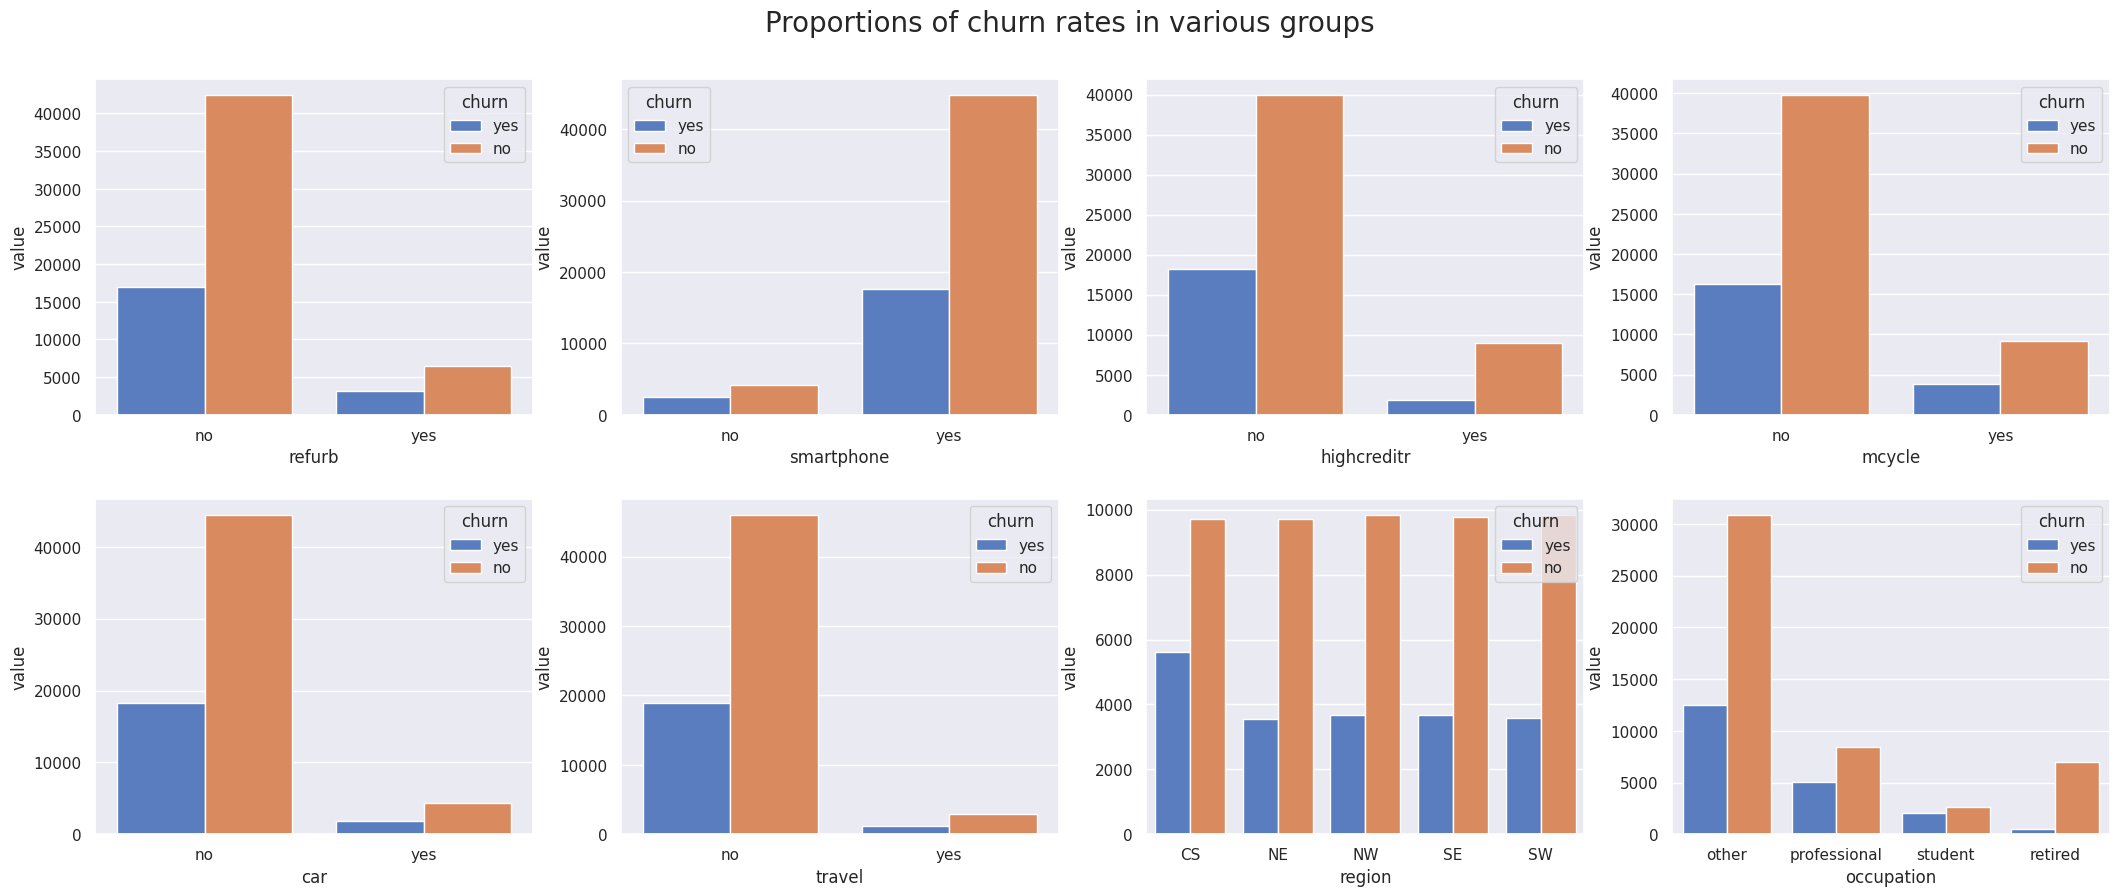

In [9]:
# Gains Plot Comparison between Test and Training Data Set
plt.figure(figsize = (26,10))
plt.subplots_adjust(hspace = 0.25)
plt.suptitle("Proportions of churn rates in various groups", fontsize = 20, y = 0.95)

for n, t in enumerate(groups):
    ax = plt.subplot(2,4,n+1)
    churn_rate_prop(t)

- Highcreditr: Customers with high credit have much lower churn rate as opposed to medium and low credit rating.
- Region: Churn rate in different regions varies, especially in CS and NE region.
- Occupation: Students have the highest churn rate, while retired people are the least likely to churn.

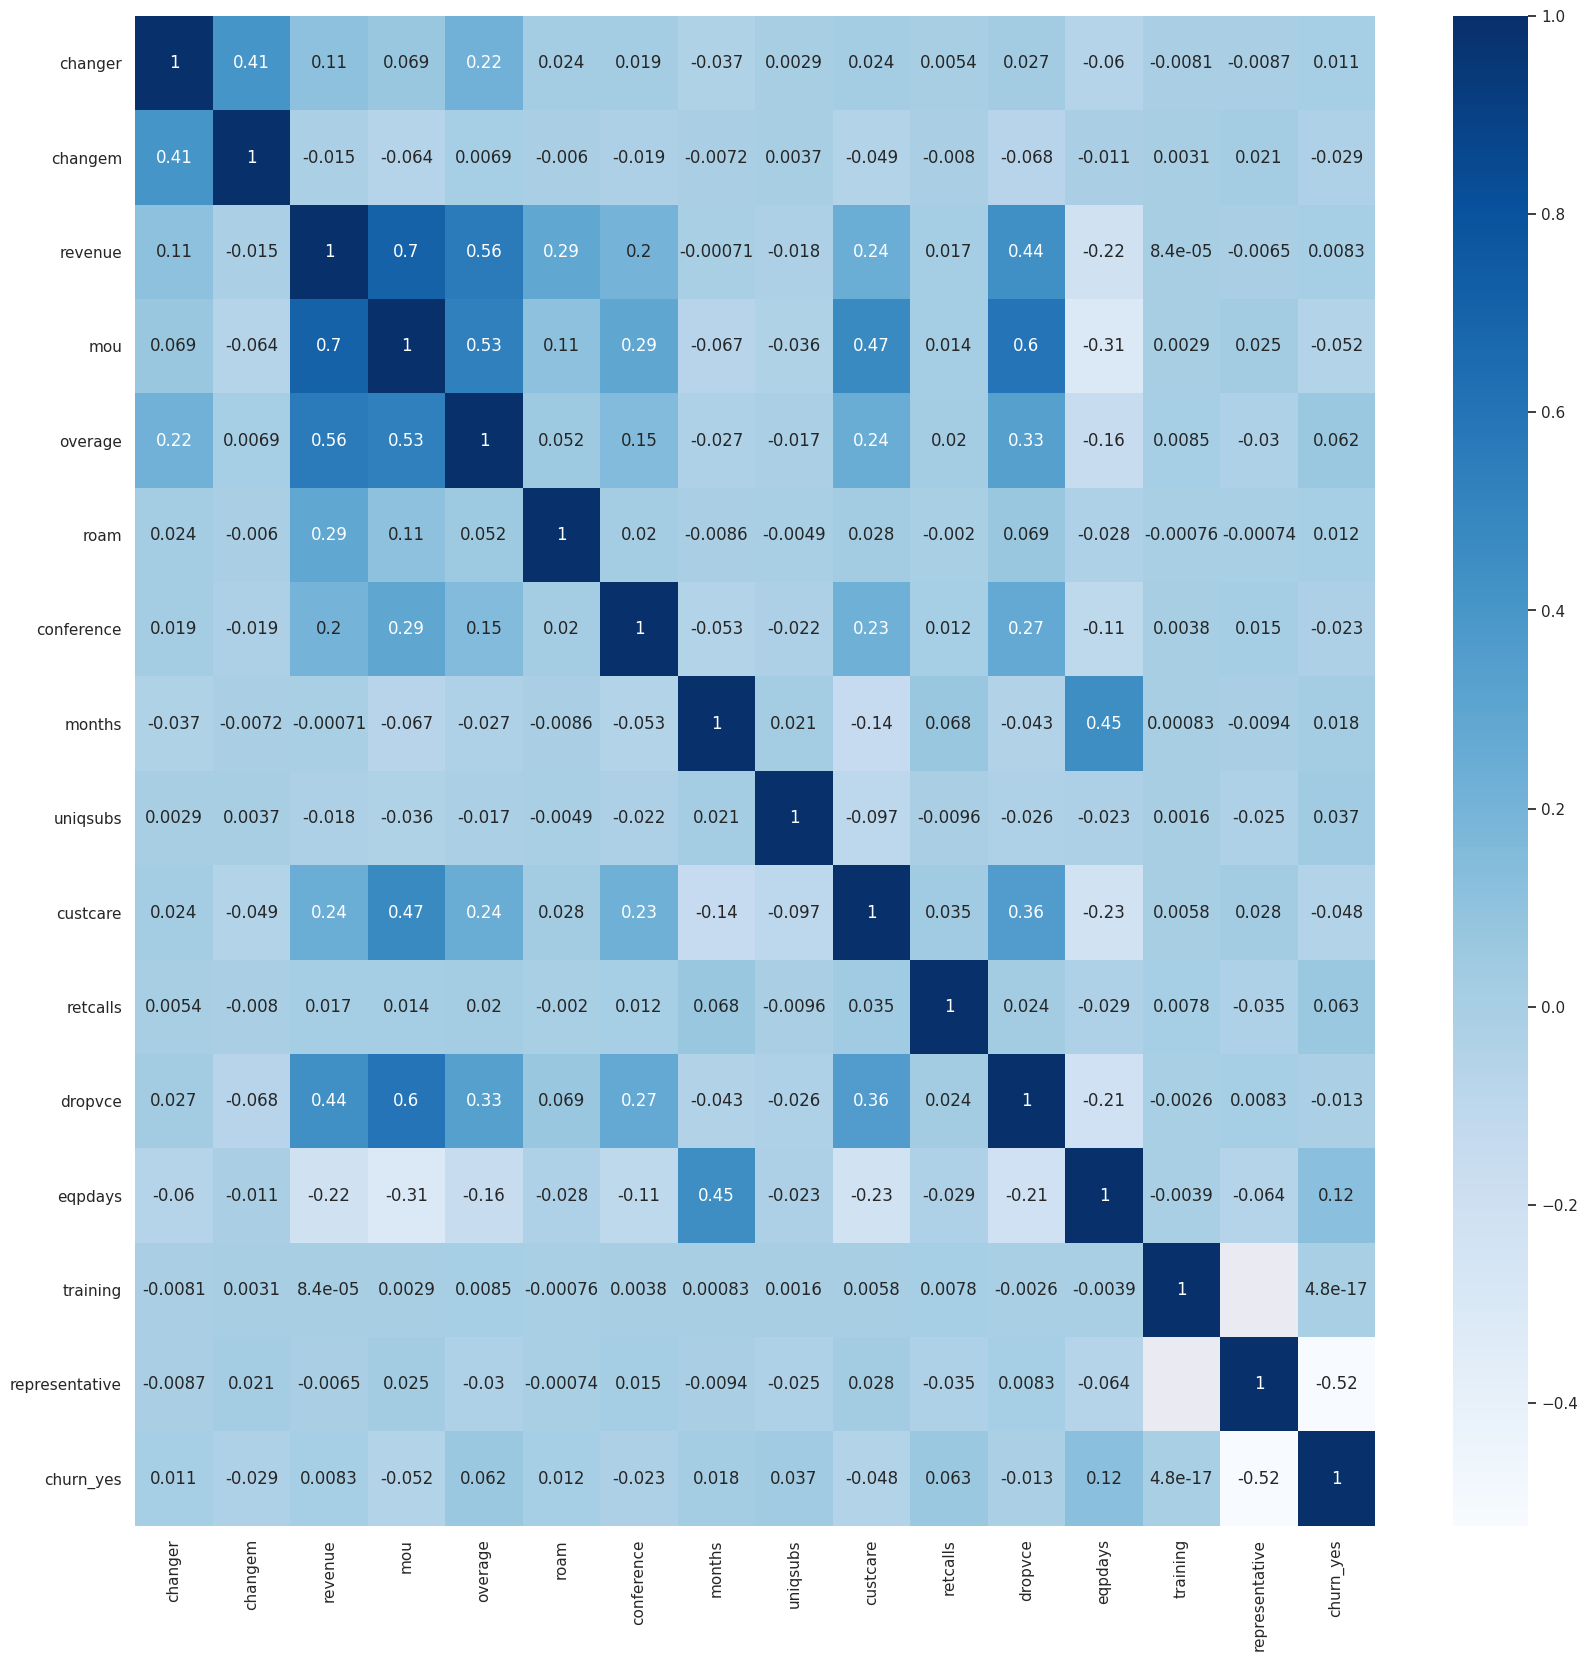

In [10]:
# Check the correlation heat map
plt.figure(figsize = (20,20))
sns.heatmap(s_mobile.corr(), annot = True, cmap="Blues")
plt.show()

## <u> Question answers </u>

### *Q1: Develop a model to predict customer churn*

In [11]:
# Define the variable

idvar = "customer"
rvar = "churn_yes"
evar = [
    "changer",
    "changem",
    "revenue",
    "mou",
    "overage",
    "roam",
    "conference",
    "months",
    "uniqsubs",
    "custcare",
    "retcalls",
    "dropvce",
    "eqpdays",
    "refurb",
    "smartphone",
    "highcreditr",
    "mcycle",
    "car",
    "region",
    "occupation",
    "travel",
]

# add weight variable for each customer
s_mobile["cweight"] = rsm.ifelse(s_mobile.churn == "yes", 1, 49)
s_mobile.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,highcreditr,mcycle,car,travel,region,occupation,training,representative,churn_yes,cweight
0,U86940794,yes,109,81,62,600,141,0,0,8,...,no,no,no,no,CS,other,0.0,0,1,1
1,U56788559,no,0,3,54,146,0,0,0,8,...,yes,no,no,no,SE,other,0.0,0,0,49
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,no,yes,no,yes,NW,professional,NaN,1,0,49
3,U75794640,no,0,-8,35,560,0,0,0,37,...,yes,yes,no,no,NW,retired,1.0,0,0,49
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,no,yes,yes,no,SW,other,NaN,1,0,49


In [12]:
# standardize the variables
Xs = rsm.scale_df(
    s_mobile.loc[:, "changer":"occupation"],
    wt=s_mobile.cweight,
    train=s_mobile.training == 1,
    sf = 2
)
Xs["churn_yes"] = s_mobile.churn_yes

Xs.head()

,changer,changem,revenue,mou,overage,roam,conference,months,uniqsubs,custcare,...,eqpdays,refurb,smartphone,highcreditr,mcycle,car,travel,region,occupation,churn_yes
0,1.795996,0.648059,0.059201,0.051482,0.583946,-0.090861,-0.126390,-0.534447,-0.299926,-0.285786,...,-0.272399,no,yes,no,no,no,no,CS,other,1
1,-0.146109,-0.134122,-0.032648,-0.364217,-0.453367,-0.090861,-0.126390,-0.534447,0.275305,-0.285786,...,-0.288119,no,yes,yes,no,no,no,SE,other,0
2,-0.146109,-0.254458,-0.204864,0.562407,0.252889,-0.090861,0.310452,-0.483883,-0.299926,1.891054,...,-0.602518,no,yes,no,yes,no,yes,NW,professional,0
3,-0.146109,-0.244430,-0.250789,0.014857,-0.453367,-0.090861,-0.126390,0.931900,-0.299926,-0.285786,...,0.172251,no,yes,yes,yes,no,no,NW,retired,0
4,-0.181744,-0.244430,0.495484,1.230822,0.370598,0.675463,-0.126390,0.072318,0.850537,-0.056645,...,-0.299347,no,yes,no,yes,yes,no,SW,other,0


### <u> LOGISTIC REGRESSION MODEL </u>

In [13]:
form = ("churn_yes ~ " + " + ".join(evar))
lr = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
    data=Xs[s_mobile.training == 1],
).fit(cov_type = "HC1")

rsm.model_fit(lr)


Pseudo R-squared (McFadden): 0.047
Pseudo R-squared (McFadden adjusted): 0.046
Area under the RO Curve (AUC): 0.688
Log-likelihood: -63795.467, AIC: 127644.935, BIC: 127953.64
Chi-squared: 691107.451 df(26), p.value < 0.001 
Nr obs: 27,300



In [14]:
rsm.or_ci(lr)

,index,OR,OR%,2.5%,97.5%,p.values,
1,refurb[T.yes],1.318,31.8%,1.255,1.385,< .001,***
2,smartphone[T.yes],0.913,-8.7%,0.860,0.969,0.003,**
3,highcreditr[T.yes],0.483,-51.7%,0.455,0.513,< .001,***
4,mcycle[T.yes],0.883,-11.7%,0.834,0.934,< .001,***
5,car[T.yes],0.991,-0.9%,0.919,1.068,0.809,
6,region[T.NE],0.644,-35.6%,0.611,0.678,< .001,***
7,region[T.NW],0.660,-34.0%,0.627,0.695,< .001,***
8,region[T.SE],0.651,-34.9%,0.618,0.685,< .001,***
9,region[T.SW],0.627,-37.3%,0.595,0.660,< .001,***
10,occupation[T.professional],1.416,41.6%,1.355,1.479,< .001,***


In [15]:
lr.wald_test_terms().table.round(3)

,statistic,pvalue,df_constraint
Intercept,10416.621,0.000,1
refurb,121.728,0.000,1
smartphone,8.950,0.003,1
highcreditr,559.722,0.000,1
mcycle,18.519,0.000,1
car,0.058,0.809,1
region,506.107,0.000,4
occupation,1693.227,0.000,3
travel,38.734,0.000,1
changer,11.976,0.001,1


In [16]:
# dropping variables with p-value > 0.01
Xs = Xs.drop(columns=['conference', 'custcare', 'car'])
Xs.head()

,changer,changem,revenue,mou,overage,roam,months,uniqsubs,retcalls,dropvce,eqpdays,refurb,smartphone,highcreditr,mcycle,travel,region,occupation,churn_yes
0,1.795996,0.648059,0.059201,0.051482,0.583946,-0.090861,-0.534447,-0.299926,-0.078858,0.105672,-0.272399,no,yes,no,no,no,CS,other,1
1,-0.146109,-0.134122,-0.032648,-0.364217,-0.453367,-0.090861,-0.534447,0.275305,-0.078858,-0.333751,-0.288119,no,yes,yes,no,no,SE,other,0
2,-0.146109,-0.254458,-0.204864,0.562407,0.252889,-0.090861,-0.483883,-0.299926,-0.078858,1.863366,-0.602518,no,yes,no,yes,yes,NW,professional,0
3,-0.146109,-0.244430,-0.250789,0.014857,-0.453367,-0.090861,0.931900,-0.299926,-0.078858,-0.333751,0.172251,no,yes,yes,yes,no,NW,retired,0
4,-0.181744,-0.244430,0.495484,1.230822,0.370598,0.675463,0.072318,0.850537,-0.078858,-0.004184,-0.299347,no,yes,no,yes,no,SW,other,0


In [17]:
#Retraining the logistic regression model after removing unnecessary features & Adding interaction terms
evar_revised = Xs.columns.tolist()[:-1]

form = ("churn_yes ~ " + " + ".join(evar_revised) + """ + occupation:mcycle + revenue:smartphone + mou:highcreditr +
                                                 eqpdays:occupation + overage:occupation + overage:highcreditr +
                                                 months:smartphone + dropvce:highcreditr + dropvce:occupation +
                                                 occupation:travel""")
lr_std = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
    data=Xs[s_mobile.training == 1],
).fit(cov_type = "HC1")

rsm.model_fit(lr_std)


Pseudo R-squared (McFadden): 0.05
Pseudo R-squared (McFadden adjusted): 0.049
Area under the RO Curve (AUC): 0.693
Log-likelihood: -63581.596, AIC: 127251.192, BIC: 127754.267
Chi-squared: 678803.413 df(43), p.value < 0.001 
Nr obs: 27,300



In [18]:
lr_std.wald_test_terms().table.round(3)

,statistic,pvalue,df_constraint
Intercept,8093.186,0.000,1
refurb,113.292,0.000,1
smartphone,14.554,0.000,1
highcreditr,490.842,0.000,1
mcycle,4.561,0.033,1
travel,0.078,0.781,1
region,480.031,0.000,4
occupation,1572.498,0.000,3
occupation:mcycle,66.678,0.000,3
occupation:travel,40.934,0.000,3


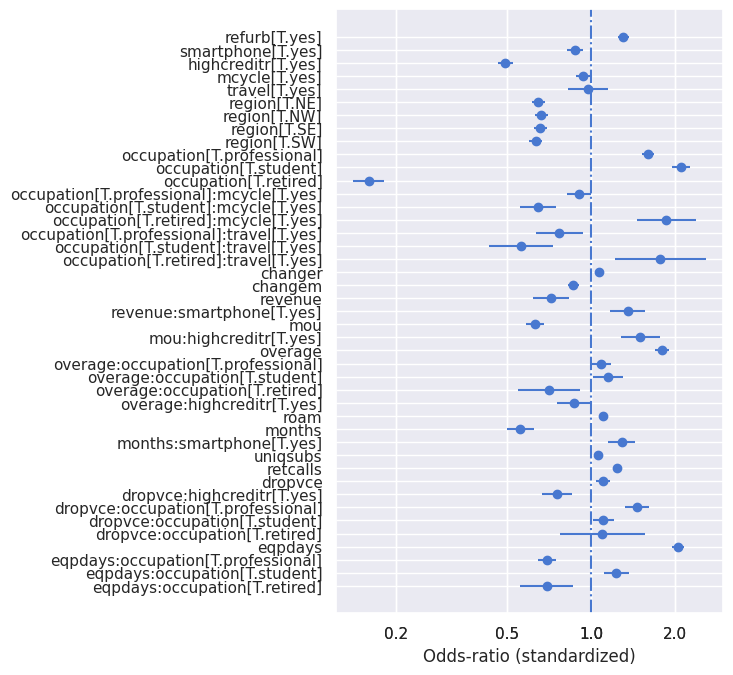

In [19]:
# plot the odds ratios
fig = rsm.or_plot(lr_std, figsize=(5,8))
fig = fig.set_xlabel("Odds-ratio (standardized)")

In [20]:
# check variable importance
(
    rsm.or_ci(lr_std, importance=True, data=s_mobile[s_mobile.training == 1])
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance,wmean,wstd,min,max
0,occupation[T.retired],0.160,-84.0%,0.141,0.182,< .001,***,True,6.241,0.137,0.344,0.0,1.0
1,occupation[T.student],2.102,110.2%,1.953,2.263,< .001,***,True,2.102,0.055,0.227,0.0,1.0
2,eqpdays,2.045,104.5%,1.943,2.152,< .001,***,False,2.045,510.298,222.647,22.0,1982.0
3,highcreditr[T.yes],0.494,-50.6%,0.464,0.526,< .001,***,True,2.023,0.180,0.384,0.0,1.0
4,occupation[T.retired]:mcycle[T.yes],1.858,85.8%,1.458,2.369,< .001,***,True,1.858,0.024,0.153,0.0,1.0
5,months,0.558,-44.2%,0.499,0.624,< .001,***,False,1.792,18.570,9.889,6.0,61.0
6,overage,1.791,79.1%,1.692,1.895,< .001,***,False,1.791,61.625,67.964,0.0,283.0
7,occupation[T.student]:travel[T.yes],0.560,-44.0%,0.430,0.729,< .001,***,True,1.786,0.007,0.085,0.0,1.0
8,occupation[T.retired]:travel[T.yes],1.772,77.2%,1.222,2.570,0.003,**,True,1.772,0.009,0.092,0.0,1.0
9,occupation[T.professional],1.597,59.7%,1.519,1.680,< .001,***,True,1.597,0.174,0.379,0.0,1.0


### <u> Gradient Boosting Model</u>

In [21]:
X = pd.get_dummies(s_mobile.loc[:, "changer":"occupation"], drop_first=True)
y = s_mobile.churn_yes

In [22]:
# XGBoost with cross-validation and grid search
grid_values = {
    "n_estimators" : list(range(100, 301, 100)),
    'max_depth' : [2]
}

scoring = {"AUC": "roc_auc"}

clf = xgb.XGBClassifier()

clf_xgb_cv = GridSearchCV(clf, param_grid = grid_values, scoring=scoring, 
                          cv=5, refit="AUC", n_jobs = 4, verbose=5)

# clf_xgb_cv.fit(X[s_mobile.training == 1], y[s_mobile.training == 1])

In [23]:
# clf_xgb_cv.best_params_

In [24]:
# clf_xgb_cv.best_score_

In [25]:
clf = xgb.XGBClassifier(
    max_depth = 2,
    n_estimators = 300,
    objective="binary:logistic",
    use_label_encoder=False,
    scale_pos_weight=1 / 49,
    eval_metric="auc",
    random_state=1234,
).fit(X[s_mobile.training == 1], y[s_mobile.training == 1], verbose=True)

In [26]:
## Check that the predicted probabilities in the representative dataset are scaled appropriately
clf.predict_proba(X[s_mobile.representative == 1])[:, 1].mean().round(3)

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.021

In [27]:
def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="lightcoral", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig

### *Q2: Use model output to understand the main drivers of churn*

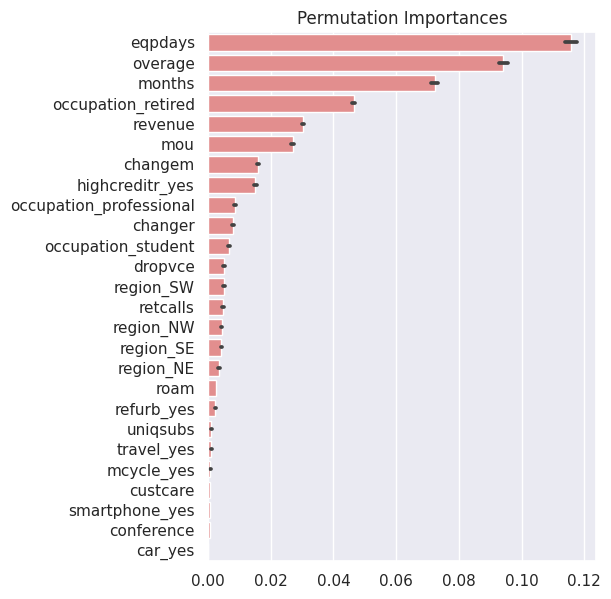

In [28]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")
# plot permutation importances
plt.figure(figsize = (5,7))
fig = importance(clf, X[s_mobile.training == 1], y[s_mobile.training == 1], X.columns)

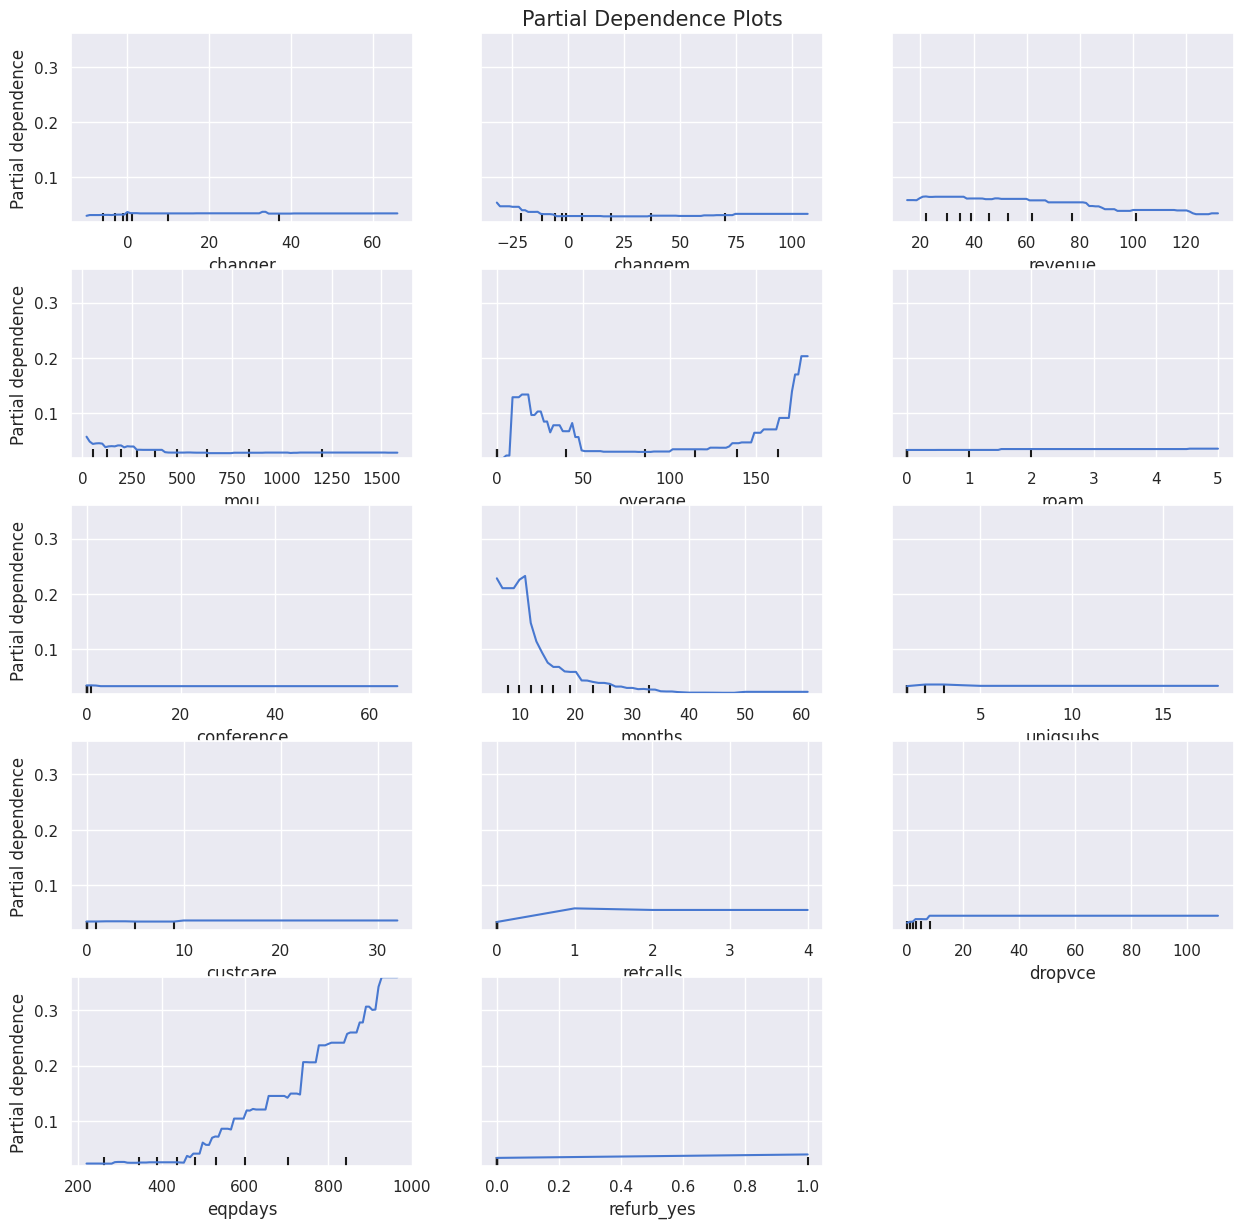

In [49]:
## Plot Top 10 
fig, ax = plt.subplots(figsize=(15, 15))
plt.subplots_adjust(hspace = 0.25)
ax.set_title("Partial Dependence Plots", fontsize = 15)
fig = plot_partial_dependence(clf, X, X.columns[0:14], ax=ax)
#plt.savefig('../data/images/Partial_dependence.png', dpi = 600,bbox_inches = "tight")

#### <u> Key drivers: </u> 

##### Besides the wald test, we checked variable importance by comparing their odds ratios. Based on the results, the top 5 factors that predict customer churns are: “eqpdays,” “overage,” “months,” “occupation,” and “revenue.” 

- “Occupation|retired” has the highest importance and OR is 0.16, meaning that compared with people with other occupations, retired people are 84% less likely to churn, keeping all else constant. On the other hand, Occupation|student” has the second highest importance while the OR is 2.103, meaning that students are 2.103 times as large as the odds for people with other occupations to churn. 

    - This is in line with our expectations as most students are very price sensitive. 
    - The comparison between retired people and other three occupation groups also indicates that occupation (without occupation|retired) is a main driver of churn.
    
        - *Hence, we developed an incentive on that in the subsequent steps.*
        


- In addition to “occupation”, “epqdays” and “month” are other two variables that have a great impact on churn probabilities. 
    - Previously, we found that “epqdays” and “month” are positively correlated. 
    - However, the more days customers have owned the current handset, the more likely they are to churn. 
    - The more months customers have had service, the less likely they are to churn. 
        
        - *We developed another incentive.*


- Lastly, we studied the effect of “highcreditr|yes” and “overage.” 
    - The odds ratios are -50.4% and 79.1%, which means that people with higher credit and people who have fewer monthly overage minutes are less likely to churn. 
    - People who have higher credit may have more stable jobs and higher income, thus they are less price-sensitive and more compliant to operator policies, while people who suffer more overage charges will consider other alternatives. 

- On top of that, we added one more driver, “dropve,” since it’s slightly correlated with “overage,” and is the only variable that conveys the service quality.

### <u> Check Models for Over-fitting </u>

In [57]:
# Function to check for overfitting between test and training data using Lift & Gains Plot

def overfitting_check(dct, model = None): 
    plt.figure(figsize = (14,6))
    plt.suptitle("Gains & Lift Plot comparison btw Test & Training data using " + model, fontsize = 12, y = 0.95)
    ax1 = plt.subplot(1, 2, 1)
    rsm.gains_plot(dct, "actual", 1, "pred", ax = ax1)
    ax2 = plt.subplot(1, 2, 2)
    rsm.lift_plot(dct, "actual", 1, 'pred', ax = ax2)
    #plt.savefig('../data/images/XGB_overfitting.png', dpi = 600,bbox_inches = "tight")
    plt.show()

In [31]:
#Check for Over-fitting XG-Boost Model
dct_xgb = {
    "train": pd.DataFrame().assign(
        actual=y[s_mobile.training == 1],
        pred=clf.predict_proba(X[s_mobile.training == 1])[:, 1],
    ),
    "test": pd.DataFrame().assign(
        actual=y[s_mobile.training == 0],
        pred=clf.predict_proba(X[s_mobile.training == 0])[:, 1],
    ),
}

# Build a tuple to collect all information
dct_logit = {
    "train": pd.DataFrame().assign(
        actual=y[s_mobile.training == 1], 
        pred=lr_std.predict(Xs[s_mobile.training == 1])
    ),
    "test": pd.DataFrame().assign(
        actual=y[s_mobile.training == 0], 
        pred=lr_std.predict(Xs[s_mobile.training == 0])
    )
}

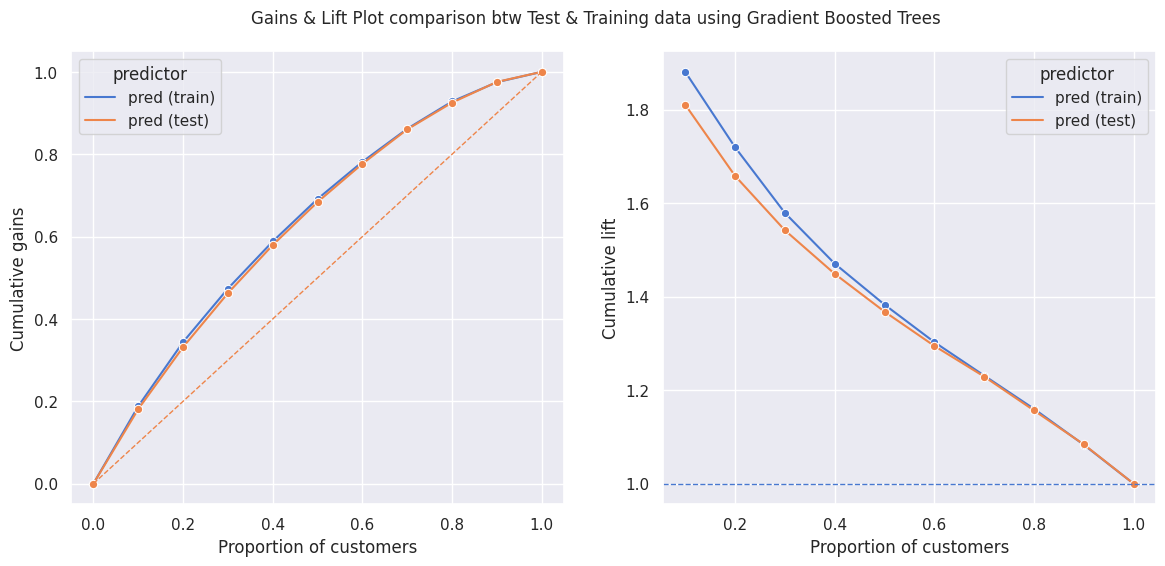

In [58]:
overfitting_check(dct = dct_xgb, model = "Gradient Boosted Trees")

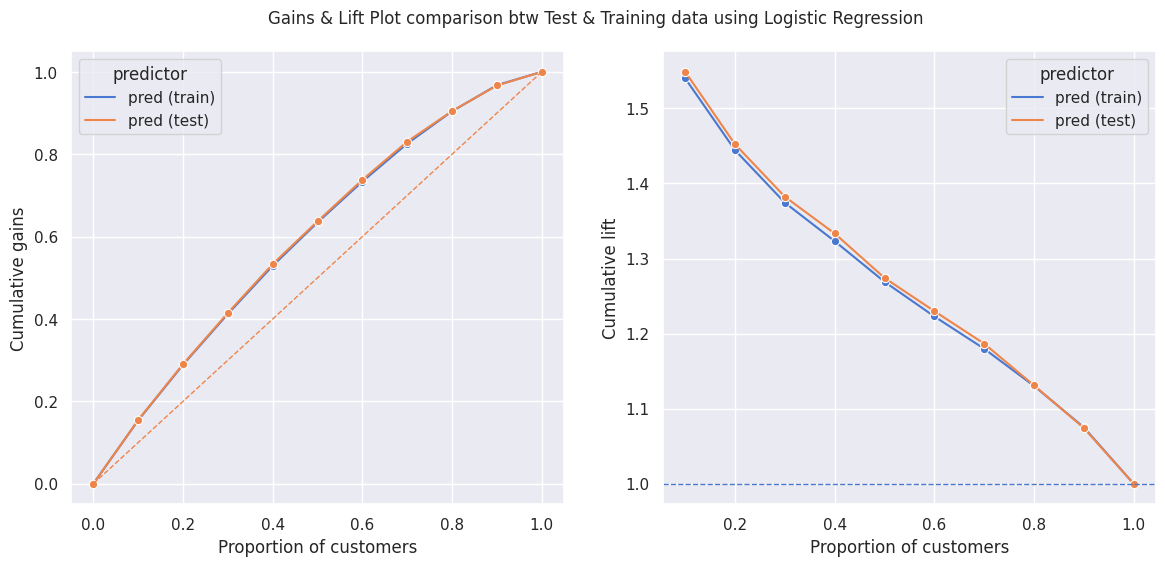

In [56]:
overfitting_check(dct = dct_logit, model = "Logistic Regression")

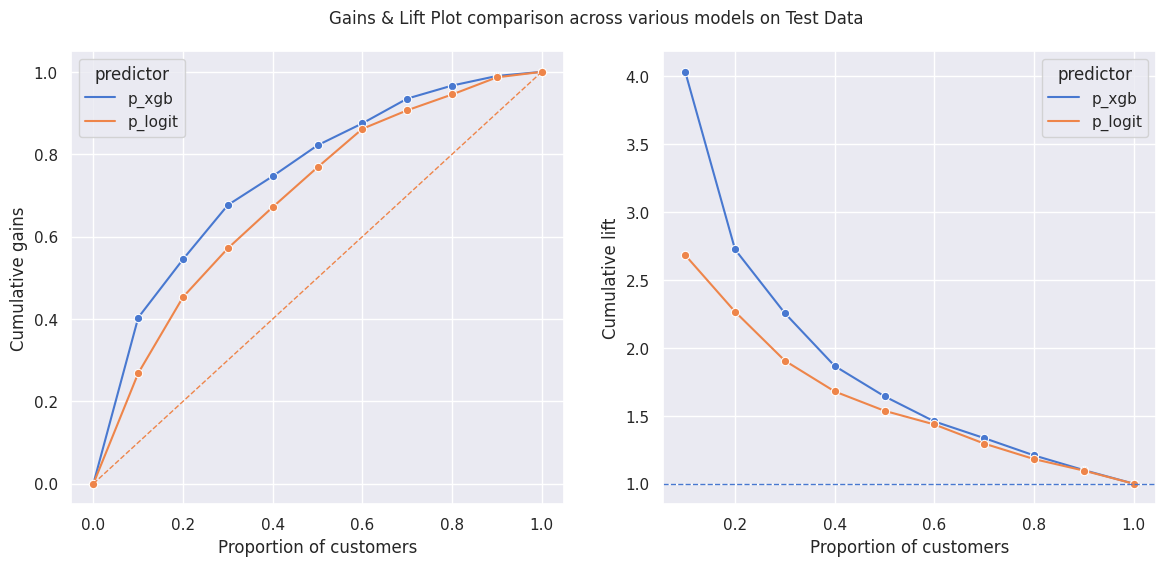

In [48]:
# no meaningful difference in performance visible

s_mobile["p_xgb"]   = clf.predict_proba(X)[:, 1]
s_mobile["p_logit"] = lr_std.predict(Xs)

plt.figure(figsize = (14,6))
plt.suptitle("Gains & Lift Plot comparison across various models on Test Data", fontsize = 12, y = 0.95)
ax1 = plt.subplot(1, 2, 1)
ax1 = rsm.gains_plot(s_mobile.query("representative == 1"), "churn_yes", 1, ["p_xgb", "p_logit"])
ax2 = plt.subplot(1, 2, 2)
ax2 = rsm.lift_plot(s_mobile.query("representative == 1"), "churn_yes", 1, ["p_xgb", "p_logit"])
#plt.savefig('../data/images/model_comparison.png', dpi = 600,bbox_inches = "tight")
plt.show()

In [35]:
dct_all = {
    "training": s_mobile[s_mobile.training == 1],
    "test": s_mobile[s_mobile.training == 0],
    "repre": s_mobile[s_mobile.representative == 1],
}

rsm.evalbin(dct_all, "churn_yes", 1, ["p_xgb", "p_logit"])

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,p_xgb,229,0,13650,13421,27300,0.017,1.0,1.0,0.033,0.508,0.017,229,1.000,1.0,0.008,0.770
1,training,p_logit,1,0,13650,13649,27300,0.000,1.0,1.0,0.000,0.500,0.000,1,0.004,1.0,0.000,0.693
2,test,p_xgb,88,0,5850,5762,11700,0.015,1.0,1.0,0.030,0.508,0.015,88,1.000,1.0,0.008,0.759
3,test,p_logit,1,0,5850,5849,11700,0.000,1.0,1.0,0.000,0.500,0.000,1,0.011,1.0,0.000,0.697
4,repre,p_xgb,7,3,29397,593,30000,0.012,1.0,0.7,0.023,0.980,0.022,4,1.000,0.4,0.000,0.758
5,repre,p_logit,0,3,29397,600,30000,0.000,1.0,0.0,NaN,0.980,-0.000,-3,-0.750,-1.0,0.000,0.702


### <u> Evaluate the profitability implications of the incentive </u>

* The following assumptions have been made for profit calculations

    - Rev = Average Revenue in the representative data set
    - Total costs including everything: 70%
        - We did research and found telecommunication industry average net profit is close to 30% Thus we use 70% as the cost of goods
    - Annually Discount Rate: 10%
    - Optimistic churn was assumed for attrition.
    - Customers will pay off their plan's charge at the beginning of each month, so we use optimistic discounting for present value.
    - Revenue is account as monthly bias, so we need to transfer annually discount rate to monthly.
    - Five years (60 month) time window.


In [36]:
## Create a dataframe used to analysis
s_mobile_rep = s_mobile.query("representative == 1").copy()
s_mobile_rep["p_base"] = lr_std.predict(Xs[s_mobile.representative == 1])
s_mobile_rep.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,travel,region,occupation,training,representative,churn_yes,cweight,p_xgb,p_logit,p_base
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,yes,NW,professional,NaN,1,0,49,0.020400,0.037892,0.037892
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,no,SW,other,NaN,1,0,49,0.012493,0.010138,0.010138
5,U18263157,no,-2,-7,45,504,73,2,0,11,...,no,SW,other,NaN,1,0,49,0.018922,0.017455,0.017455
7,U18798421,no,96,38,60,777,133,0,1,7,...,no,NW,other,NaN,1,0,49,0.002667,0.010844,0.010844
10,U30117312,no,1,126,30,19,0,0,0,13,...,no,NW,other,NaN,1,0,49,0.008543,0.007336,0.007336


In [37]:
def clv_calculator(churn_column):
    churn = churn_column

    retention = [1]
    for i in range(1,60):
        value = (1-churn[i-1])* retention[i-1]
        retention.append(value)

    nr_years = 5
    cost_service = 0.70
    annual_discount_rate = 0.1
    monthly_discount_rate = pow(1 + annual_discount_rate, (1/12)) - 1
    monthly_revenue = np.repeat(s_mobile_rep.revenue.mean(), nr_years*12)

    time = np.arange(0, nr_years * 12)
    costs = cost_service * monthly_revenue
    profit = monthly_revenue - costs
    exp_profit = retention * profit
    pv_exp_profit = exp_profit / np.power(1 + monthly_discount_rate, time)
    clv_nap = np.cumsum(pv_exp_profit)

    return clv_nap[-1].round(2)

#### <u> *Target : Overage* </u>

In [38]:
## Predict the probability
s_mobile_rep["p_overage_ave"] = lr_std.predict(Xs[s_mobile.representative == 1].assign(overage=Xs[s_mobile.representative == 1].overage.mean()))

## Compare churn before and after
s_mobile_rep.loc[
    (s_mobile_rep.overage > s_mobile_rep.overage.mean()) &
    (s_mobile.occupation != 'retired') &
    (s_mobile.highcreditr == 'no') 
    & (s_mobile_rep.p_base > s_mobile_rep.p_base.mean()),
    ["churn_yes", "p_overage_ave"],
].agg(["count", "mean"]).round(4)

,churn_yes,p_overage_ave
count,6586.0000,6586.0000
mean,0.0333,0.0269


In [39]:
## Create df to collect churn
df_churn = pd.DataFrame(
    {"overage_churn": np.repeat(0.0333, 61), "no_overage_churn": np.repeat(0.0269, 61)}
)
df_churn.loc[0] = 0

## CLV before target
overage = clv_calculator(df_churn.iloc[:-1, 0])
print("CLV with current overage: $", (overage))

## CLV after target
no_overage = clv_calculator(df_churn.iloc[:-1, 1])
print("CLV after targeting: $", (no_overage))
## Print out result

print("The CLV difference: $", (no_overage - overage).round(2))

CLV with current overage: $ 393.71
CLV after targeting: $ 443.16
The CLV difference: $ 49.45


#### <u> *Target : eqpdays* </u>

In [40]:
## Predict the probability
s_mobile_rep["p_eqpdays_ave"] = lr_std.predict(Xs[s_mobile.representative == 1].assign(eqpdays=Xs[s_mobile.representative == 1].eqpdays.mean()))

## Compare churn before and after
s_mobile_rep.loc[
    (s_mobile_rep.eqpdays > s_mobile_rep.eqpdays.mean()) &
    (s_mobile.occupation != 'retired') &
    (s_mobile.highcreditr == 'no')
    & (s_mobile_rep.p_base > s_mobile_rep.p_base.mean()),
    ["churn_yes", "p_eqpdays_ave"],
].agg(["count", "mean"]).round(4)

,churn_yes,p_eqpdays_ave
count,6826.0000,6826.0000
mean,0.0372,0.0254


In [59]:
s_mobile_rep.eqpdays.mean()

509.33886666666666

In [41]:
## Create df to collect churn
df_churn = pd.DataFrame(
    {"overage_churn": np.repeat(0.0372, 61), "no_overage_churn": np.repeat(0.0254, 61)}
)
df_churn.loc[0] = 0

## CLV before target
eqpdays = clv_calculator(df_churn.iloc[:-1, 0])
print("CLV with current eqpdays: $", (eqpdays))

## CLV after target
no_eqpdays = clv_calculator(df_churn.iloc[:-1, 1])
print("CLV after targeting: $", (no_eqpdays))
## Print out result

print("The CLV difference: $", (no_eqpdays - eqpdays).round(2))

CLV with current eqpdays: $ 367.96
CLV after targeting: $ 456.25
The CLV difference: $ 88.29


#### <u> *Target : drpvce* </u>

In [42]:
## Predict the probability
s_mobile_rep["p_dropvce_ave"] = lr_std.predict(Xs[s_mobile.representative == 1].assign(dropvce=Xs[s_mobile.representative == 1].dropvce.mean()))

## Compare churn before and after
s_mobile_rep.loc[
    (s_mobile_rep.dropvce > s_mobile_rep.dropvce.mean()) &
    (s_mobile.occupation != 'retired') &
    (s_mobile.highcreditr == 'no') 
    & (s_mobile_rep.p_base > s_mobile_rep.p_base.mean()),
    ["churn_yes", "p_dropvce_ave"],
].agg(["count", "mean"]).round(4)

,churn_yes,p_dropvce_ave
count,2880.0000,2880.0000
mean,0.0354,0.0315


In [60]:
s_mobile_rep.dropvce.mean()

3.0299666666666667

In [43]:
## Create df to collect churn
df_churn = pd.DataFrame(
    {"overage_churn": np.repeat(0.0354, 61), "no_overage_churn": np.repeat(0.0315, 61)}
)
df_churn.loc[0] = 0

## CLV before target
dropvce = clv_calculator(df_churn.iloc[:-1, 0])
print("CLV with current dropvce: $", (dropvce))

## CLV after target
no_dropvce = clv_calculator(df_churn.iloc[:-1, 1])
print("CLV after targeting: $", (no_dropvce))
## Print out result

print("The CLV difference: $", (no_dropvce - dropvce).round(2))

CLV with current dropvce: $ 379.47
CLV after targeting: $ 406.65
The CLV difference: $ 27.18


#### <u> *Target : uniqsubs* </u>

In [44]:
## Predict the probability
s_mobile_rep["p_uniqsubs_ave"] = lr_std.predict(Xs[s_mobile.representative == 1].assign(uniqsubs=Xs[s_mobile.representative == 1].uniqsubs.mean()))

## Compare churn before and after
s_mobile_rep.loc[
    (s_mobile_rep.uniqsubs > s_mobile_rep.uniqsubs.mean())&
    (s_mobile.occupation != 'retired') &
    (s_mobile.highcreditr == 'no') 
    & (s_mobile_rep.p_base > s_mobile_rep.p_base.mean()),
    ["churn_yes", "p_uniqsubs_ave"],
].agg(["count", "mean"]).round(4)

,churn_yes,p_uniqsubs_ave
count,4844.0000,4844.0000
mean,0.0347,0.0324


In [45]:
## Create df to collect churn
df_churn = pd.DataFrame(
    {"overage_churn": np.repeat(0.0347, 61), "no_overage_churn": np.repeat(0.0324, 61)}
)
df_churn.loc[0] = 0

## CLV before target
uniqsubs = clv_calculator(df_churn.iloc[:-1, 0])
print("CLV with current uniqsubs: $", (uniqsubs))

## CLV after target
no_uniqsubs = clv_calculator(df_churn.iloc[:-1, 1])
print("CLV after targeting: $", (no_uniqsubs))
## Print out result

print("The CLV difference: $", (no_uniqsubs - uniqsubs).round(2))

CLV with current uniqsubs: $ 384.12
CLV after targeting: $ 400.09
The CLV difference: $ 15.97


## <u> Develop incentives and quantify their impacts </u>


#### After realizing the key drivers in customers churn, we can develop different incentives plans based on different categories of those key drivers. 

#### We will focus on customer usage, quality, and equipment characteristics to develop plans, and then we will use customer characteristics to further filter out our target customers for incentives. 

#### <u> 1.Customer usage with customer characteristics: </u>

        
- Variable “overage” has a positive impact on a customer’s churn rate, as the monthly overage minutes increase, the customer is more likely to churn. The plan will target customers who have more than average overage minutes and their predicted churn rate is higher than then average. Then, we will further filter out customers as student occupations and their credit scores are not high as our incentives target. 

    - Impact of the incentives:
    
|                       | Current     |  Incentive|
| -----------           | ----------- |-----------|
| # of Customers        | 6586        | 6586      |
| Churn Rate            | 0.0333      | 0.0269    |
| CLV ( per customer)   | 393.71      | 443.16    |


    - Economics: The total CLV difference in 60 months before and after incentives is 49.45.
    
#### <u> Quality with customer characteristics: </u>

- Variable “dropvce” has a positive impact on a customer’s churn rate, as the monthly dropped voice calls increase, the customer is more likely to churn. The plan will target customers who have more than average dropped calls and their predicted churn rate is higher than then average. Then, we will further filter out customers as student occupations and their credit scores are not high as our incentives target. 

    - Impact of the incentives:
 
|                       | Current     |  Incentive|
| -----------           | ----------- |-----------|
| # of Customers        | 2880        | 2880      |
| Churn Rate            | 0.0354      | 0.0315    |
| CLV ( per customer)   | 379.47      | 406.65    |

    - Economics: The total CLV difference in 60 months before and after incentives is 27.18.

#### <u> Equipment characteristics with customer characteristics: </u>

- Variable “eqpdays” has a positive impact on a customers churn rate, as the number of days the customer owned the current handset increases, the customer is more likely to churn. The plan will target customers who have more than average number of days owned the current handset and their predicted churn rate is higher than then average. Then, we will further filter out customers as student occupations and their credit scores are not high as our incentives target.

    -  Impact of the incentives:
    
|                       | Current     |  Incentive |
| -----------           | ----------- |----------- |
| # of Customers        | 6826        | 6826       |
| Churn Rate            | 0.0372      | 0.0254     |
| CLV ( per customer)   | 368         | 456        |   


    - Economics: The total CLV difference in 60 months before and after incentives is 88.29.

### <u> *Overall, the best two incentives plans are: overage with occupations and credit score and eqpdays with occupations and credit score. Both of these plans will target around 23% customers.* </u>